This notebook demonstrates use of a TF-Hub module trained to perform object detection.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import (Image, ImageColor, ImageDraw, ImageFont, ImageOps)

import time
print(tf.__version__)
print("The following GPU devices are available: %s"%tf.test.gpu_device_name())

IMG_WIDTH, IMG_HEIGHT = (256, 256)

2.1.0
The following GPU devices are available: /device:GPU:0


In [2]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [3]:
def display_image(image, figure=False):
    if figure:
        fig = plt.figure(figsize=(20,15))
    plt.grid(False)
    plt.imshow(image, interpolation="nearest")
    

In [4]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
                (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                        fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                    display_str,
                    fill="black",
                    font=font)
        text_bottom -= text_height - 2 * margin

In [5]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(image_pil,
                                        ymin,
                                        xmin,
                                        ymax,
                                        xmax,
                                        color,
                                        font,
                                        display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

In [6]:
DIR_PATH = "../input/open-images-object-detection-rvc-2020/test/"
test_image_paths = [os.path.join(DIR_PATH, i) for i in os.listdir(DIR_PATH)]

### Visualizing Test Images

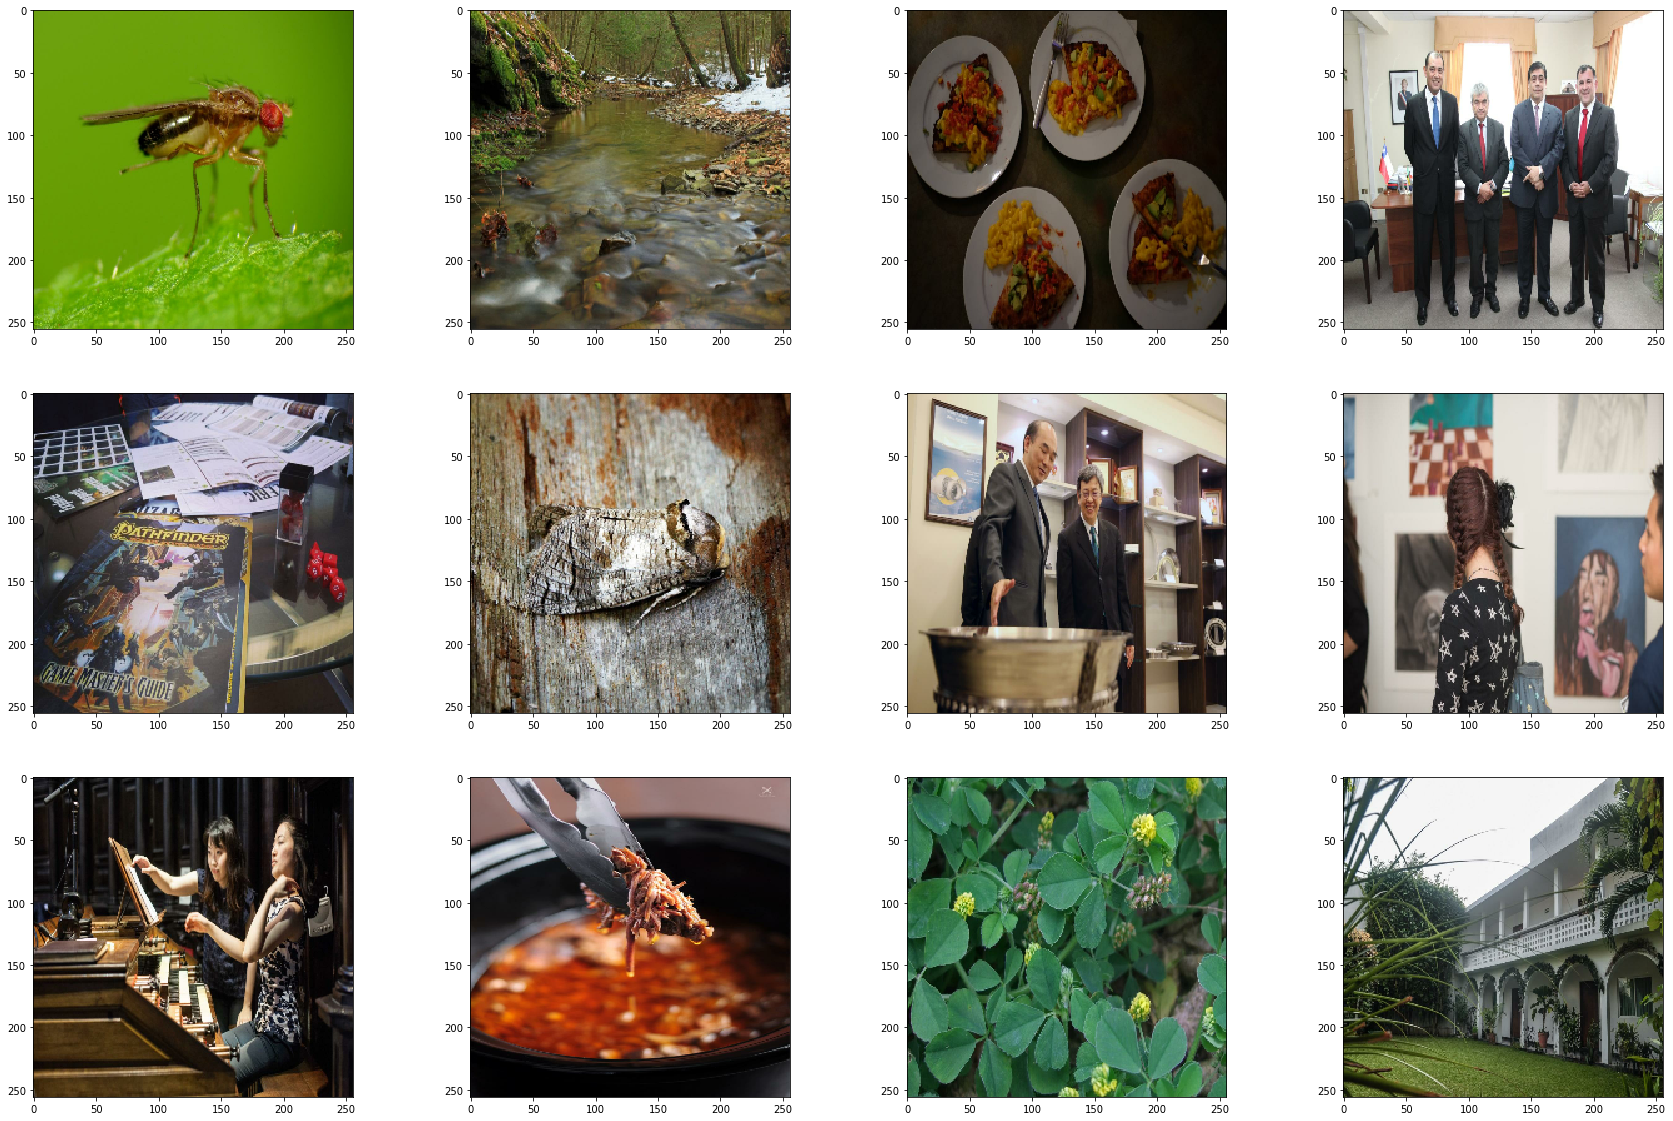

In [7]:
plt.figure(figsize=(30,20))
for i in range(12):
    plt.subplot(3,4,i+1)
    display_image(load_img(test_image_paths[np.random.randint(0,len(test_image_paths))]))
    plt.grid(False)

### Load Model

In [8]:
import gc
gc.collect()
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 
detector = hub.load(module_handle).signatures['default']

In [9]:
def run_detector(detector, path):
    img = load_img(path)

    converted_img  = img[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()
    result = {key:value.numpy() for key,value in result.items()}
    return result

### Test Detector

In [10]:
%%time
result = run_detector(detector, test_image_paths[0])

CPU times: user 49.1 s, sys: 1.44 s, total: 50.5 s
Wall time: 52.9 s


### Predict on Test Images

In [11]:
def format_prediction_string(image_id, result):
    prediction_strings = []
    
    for i in range(len(result['detection_scores'])):
        class_name = result['detection_class_names'][i].decode("utf-8")
        YMin,XMin,YMax,XMax = result['detection_boxes'][i]
        score = result['detection_scores'][i]
        
        prediction_strings.append(
            f"{class_name} {score} {XMin} {YMin} {XMax} {YMax}"
        )
        
    prediction_string = " ".join(prediction_strings)

    return {
        "ImageID": image_id,
        "PredictionString": prediction_string
    }

In [12]:
def detect_img(id):
    path = DIR_PATH + id +".jpg"
    result = run_detector(detector, path)
    pred = format_prediction_string(id, result)
    return pred

In [13]:
submission = pd.read_csv('../input/open-images-object-detection-rvc-2020/sample_submission.csv')

In [14]:
predictions = []
total_time = 0
for idx in tqdm(range(len(submission))):
    start_time = time.time()
    predictions.append(detect_img(submission.ImageId[idx]))
    end_time = time.time()
    #print("Inference time:",end_time - start_time)
    total_time+=end_time-start_time
    if total_time>10620:
        print(idx)
        print("Exit. Limited Time Elapsed")
        break

 10%|▉         | 9529/99999 [2:57:11<28:02:14,  1.12s/it]

9529
Exit. Limited Time Elapsed


In [15]:
pd.DataFrame(predictions).to_csv('submission.csv', index=False)